In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                     #transforms.Resize((28, 28)),
                                     transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                     #transforms.RandomRotation((-7.0, 7.0)),
                                     #transforms.RandomGrayscale(p=0.01),        
                                     #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))
                                       # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

/home/rogbot/deepvision/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=16, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
import torch.nn.functional as F
dropout_value = 0.01

class NetLN(nn.Module):
    def __init__(self):
        super(NetLN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([11, 26, 26]),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=19, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.LayerNorm([19, 24, 24]),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=19, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            nn.LayerNorm([10, 24, 24]),

        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.LayerNorm([15, 10, 10]),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.LayerNorm([15, 8, 8]),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.LayerNorm([15, 6, 6]),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.LayerNorm([15, 6, 6]),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

       
        self.fc = nn.Sequential(
            nn.Linear(15, 10,bias=False),
            nn.BatchNorm1d(10),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)   
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
modelLN = NetLN().to(device)
summary(modelLN, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 26, 26]              99
              ReLU-2           [-1, 11, 26, 26]               0
         LayerNorm-3           [-1, 11, 26, 26]          14,872
           Dropout-4           [-1, 11, 26, 26]               0
            Conv2d-5           [-1, 19, 24, 24]           1,881
              ReLU-6           [-1, 19, 24, 24]               0
         LayerNorm-7           [-1, 19, 24, 24]          21,888
           Dropout-8           [-1, 19, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             190
        LayerNorm-10           [-1, 10, 24, 24]          11,520
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 15, 10, 10]           1,350
             ReLU-13           [-1, 15, 10, 10]               0
        LayerNorm-14           [-1

In [7]:
import torch.nn.functional as F
dropout_value = 0.01

class NetGN(nn.Module):
    def __init__(self):
        super(NetGN, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(11),
            nn.GroupNorm(1, 11),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=19, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(19),
            nn.GroupNorm(1, 19),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=19, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            nn.GroupNorm(5, 10),

        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(15),
            nn.GroupNorm(5, 15),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(15),
            nn.GroupNorm(5, 15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(15),
            nn.GroupNorm(5, 15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(15),
            nn.GroupNorm(5, 15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

       
        self.fc = nn.Sequential(
            nn.Linear(15, 10,bias=False),
            nn.BatchNorm1d(10),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)   
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=-1)

In [8]:
modelGN = NetGN().to(device)
summary(modelGN, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 26, 26]              99
              ReLU-2           [-1, 11, 26, 26]               0
         GroupNorm-3           [-1, 11, 26, 26]              22
           Dropout-4           [-1, 11, 26, 26]               0
            Conv2d-5           [-1, 19, 24, 24]           1,881
              ReLU-6           [-1, 19, 24, 24]               0
         GroupNorm-7           [-1, 19, 24, 24]              38
           Dropout-8           [-1, 19, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             190
        GroupNorm-10           [-1, 10, 24, 24]              20
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 15, 10, 10]           1,350
             ReLU-13           [-1, 15, 10, 10]               0
        GroupNorm-14           [-1, 15,

In [9]:
import torch.nn.functional as F
dropout_value = 0.01

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=11, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(11),
            #nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=11, out_channels=19, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(19),
            #nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=19, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),

        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1
       
        self.fc = nn.Sequential(
            nn.Linear(15, 10,bias=False),
            nn.BatchNorm1d(10),
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)   
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return F.log_softmax(x, dim=-1)

In [10]:
modelBNL1 = Net().to(device)
summary(modelBNL1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 11, 26, 26]              99
              ReLU-2           [-1, 11, 26, 26]               0
       BatchNorm2d-3           [-1, 11, 26, 26]              22
            Conv2d-4           [-1, 19, 24, 24]           1,881
              ReLU-5           [-1, 19, 24, 24]               0
       BatchNorm2d-6           [-1, 19, 24, 24]              38
            Conv2d-7           [-1, 10, 24, 24]             190
       BatchNorm2d-8           [-1, 10, 24, 24]              20
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 15, 10, 10]           1,350
             ReLU-11           [-1, 15, 10, 10]               0
      BatchNorm2d-12           [-1, 15, 10, 10]              30
          Dropout-13           [-1, 15, 10, 10]               0
           Conv2d-14             [-1, 1

In [11]:
from tqdm import tqdm

train_lossesLN = []
test_lossesLN = []
train_accLN = []
test_accLN = []

def trainLN(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_lossesLN.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_accLN.append(100*correct/processed)

def testLN(model, device, test_loader):
    model.eval()
    test_lossLN = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_lossLN += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_lossLN /= len(test_loader.dataset)
    test_lossesLN.append(test_lossLN)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_lossLN, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_accLN.append(100. * correct / len(test_loader.dataset))

In [12]:
train_lossesGN = []
test_lossesGN = []
train_accGN = []
test_accGN = []

def trainGN(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_lossesGN.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_accGN.append(100*correct/processed)

def testGN(model, device, test_loader):
    model.eval()
    test_lossGN = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_lossGN += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_lossGN /= len(test_loader.dataset)
    test_lossesGN.append(test_lossGN)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_lossGN, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_accGN.append(100. * correct / len(test_loader.dataset))

In [13]:
from tqdm import tqdm
from torch.autograd import Variable

train_losses = []
test_losses = []
train_acc = []
test_acc = []

lambda_ = 0.0005

def train(model, device, train_loader, optimizer, epoch, choice):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    # L1 Regulizer for choice = 3    
    if(choice == 3):
        l1_reg = None
        for w in model.parameters():
            if l1_reg is None:
                l1_reg = w.abs().sum()
            else:
                l1_reg = l1_reg + w.abs().sum()
            
        loss += lambda_*l1_reg
   
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [14]:
# Take user input

print("ENTER CHOICE OF NORM : 1. Layer Normalization 2. Group Normalization 3. Batch Normalization with L1 Regularization")
choice = int(input())
print("YOU HAVE ENTERED : ",choice)

ENTER CHOICE OF NORM : 1. Layer Normalization 2. Group Normalization 3. Batch Normalization with L1 Regularization
1
YOU HAVE ENTERED :  1


In [15]:
from torch.optim.lr_scheduler import StepLR

model = None

if(choice==1):
    model = NetLN().to(device)
    
if(choice==2):
    model = NetGN().to(device)
    
if(choice==3):
    model = Net().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#scheduler = StepLR(optimizer, step_size=6, gamma=0.00001)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, choice)    
    #scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.052911169826984406 Batch_id=937 Accuracy=94.56: 100%|█| 938/938 [00:11<00



Test set: Average loss: 0.0690, Accuracy: 9838/10000 (98.38%)

EPOCH: 1


Loss=0.021830162033438683 Batch_id=937 Accuracy=97.69: 100%|█| 938/938 [00:10<00



Test set: Average loss: 0.0537, Accuracy: 9835/10000 (98.35%)

EPOCH: 2


Loss=0.1325439065694809 Batch_id=937 Accuracy=98.11: 100%|█| 938/938 [00:10<00:0



Test set: Average loss: 0.0398, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.004120043478906155 Batch_id=937 Accuracy=98.42: 100%|█| 938/938 [00:11<00



Test set: Average loss: 0.0328, Accuracy: 9907/10000 (99.07%)

EPOCH: 4


Loss=0.0415821447968483 Batch_id=937 Accuracy=98.57: 100%|█| 938/938 [00:11<00:0



Test set: Average loss: 0.0255, Accuracy: 9923/10000 (99.23%)

EPOCH: 5


Loss=0.08374308794736862 Batch_id=937 Accuracy=98.73: 100%|█| 938/938 [00:11<00:



Test set: Average loss: 0.0261, Accuracy: 9926/10000 (99.26%)

EPOCH: 6


Loss=0.14336758852005005 Batch_id=937 Accuracy=98.86: 100%|█| 938/938 [00:11<00:



Test set: Average loss: 0.0276, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.03055093251168728 Batch_id=937 Accuracy=98.90: 100%|█| 938/938 [00:11<00:



Test set: Average loss: 0.0241, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.03531336411833763 Batch_id=937 Accuracy=98.95: 100%|█| 938/938 [00:11<00:



Test set: Average loss: 0.0233, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.2700915038585663 Batch_id=937 Accuracy=99.03: 100%|█| 938/938 [00:11<00:0



Test set: Average loss: 0.0238, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.0037484795320779085 Batch_id=937 Accuracy=99.10: 100%|█| 938/938 [00:11<0



Test set: Average loss: 0.0255, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


Loss=0.014630637131631374 Batch_id=937 Accuracy=99.09: 100%|█| 938/938 [00:11<00



Test set: Average loss: 0.0234, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.03333238512277603 Batch_id=937 Accuracy=99.14: 100%|█| 938/938 [00:11<00:



Test set: Average loss: 0.0240, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


Loss=0.013255017809569836 Batch_id=937 Accuracy=99.20: 100%|█| 938/938 [00:11<00



Test set: Average loss: 0.0240, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.02361469902098179 Batch_id=937 Accuracy=99.27: 100%|█| 938/938 [00:11<00:



Test set: Average loss: 0.0213, Accuracy: 9939/10000 (99.39%)

EPOCH: 15


Loss=0.07593724876642227 Batch_id=937 Accuracy=99.31: 100%|█| 938/938 [00:12<00:



Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Loss=0.019847027957439423 Batch_id=937 Accuracy=99.30: 100%|█| 938/938 [00:11<00



Test set: Average loss: 0.0228, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.009550529532134533 Batch_id=937 Accuracy=99.34: 100%|█| 938/938 [00:11<00



Test set: Average loss: 0.0231, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.08205718547105789 Batch_id=937 Accuracy=99.32: 100%|█| 938/938 [00:11<00:



Test set: Average loss: 0.0210, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.013376195915043354 Batch_id=937 Accuracy=99.38: 100%|█| 938/938 [00:11<00



Test set: Average loss: 0.0215, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

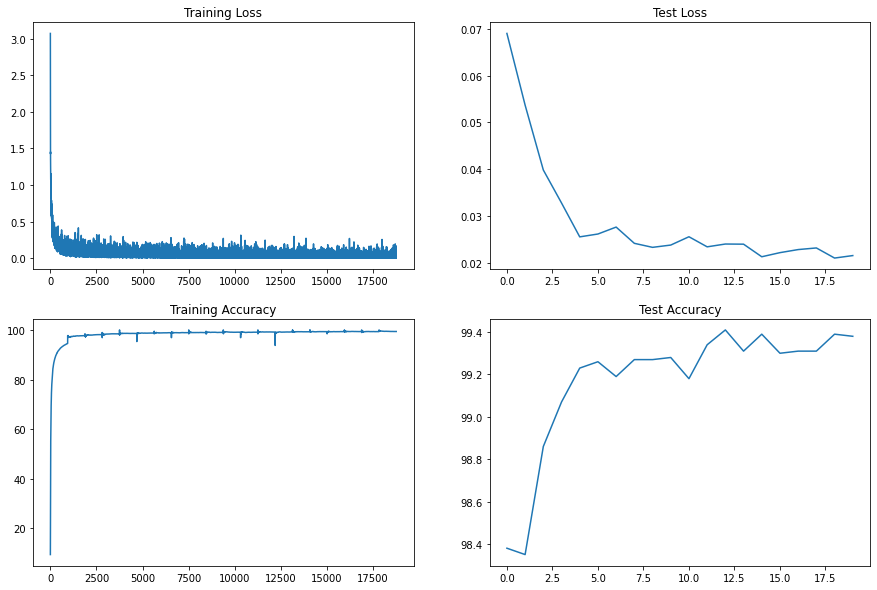

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy

train_losses_cpu = []
for loss in train_losses:
    train_losses_cpu.append(loss.cpu().data.numpy())  

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_cpu)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")